### Notebook to develop threshold for blue band for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

### Import packages

In [4]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry.polygon import Polygon
import earthpy.spatial as es
import scipy
import matplotlib.pyplot as plt
import matplotlib
import itertools

# base directory
basepath = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
impath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SR-stitched/'
# output folder
outpath = basepath+'imagery/Planet/2021-04-20_2021-08-25/MNDSI'

### Define Area of Interest (AOI)
#### Read in a shapefile with AOI polygon

In [5]:
# Load shapefile
fn = basepath+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
print('Original shapefile CRS:',AOI.crs)

# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(32606)

# print information
print('Reprojected shapefile CRS: ',AOI.crs)
print('Shapefile bounds:',AOI.boundary)

Original shapefile CRS: epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTILINESTRING ((393342.531 6698475.452, 3933...
dtype: geometry


### Load image and shapefiles for tuning threshold: digitized snow line & transect

In [6]:
# image
os.chdir(impath) # change directory
im_name = glob.glob('20210611.tif')
print('Image: ',im_name[0])
print('')

# snowline
sl_fn = basepath+'imagery/Planet/2021-04-20_2021-08-25/digitized_snowline_picks/20210611_snowline.shp'
sl = gpd.read_file(sl_fn) # snowline
print('Snowline CRS: ',sl.crs)
# Reproject to imagery CRS if necessary
sl = sl.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',sl.crs)
print('Shapefile bounds:',sl.boundary)
print('')

# transect
ts_fn = basepath+'imagery/Planet/2021-04-20_2021-08-25/digitized_snowline_picks/20210611_transect.shp'
ts = gpd.read_file(ts_fn) # snowline
print('Transect CRS: ',ts.crs)
# Reproject to imagery CRS if necessary
ts = ts.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',ts.crs)
print('Shapefile bounds:',ts.boundary)

Image:  20210611.tif

Snowline CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (393822.330 6696510.680, 394827.218...
dtype: geometry

Transect CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (395302.318 6697506.970, 394695.292...
dtype: geometry


### Identify snow by adjusting thresholds

In [56]:
# Define thresholds
thresh_min = 0.32
thresh_max = 0.42

# open image
im = rio.open(im_name[0])

# define bands, convert to TOA reflectance
refl_coeff = 5.12134605626e-05 # from image metadata
blue = im.read(1)*refl_coeff

# threshold MNDSI to determine snow cover
snow = np.where((blue>thresh_min),1,np.nan)

### interpolate MNDSI along transect 
# extract points from geometry
ts_pts = [i for i in ts.geometry]
ts_x,ts_y = ts_pts[0].coords.xy
ts_coords = np.dstack((ts_x,ts_y)).tolist()
# sample raster values at coordinates
ts_rv = [x for x in im.sample(ts_coords[0])]
ts_blue = []
# extract blue raster values
for point in ts_rv:
    ts_blue = ts_blue + [point[0]*refl_coeff]

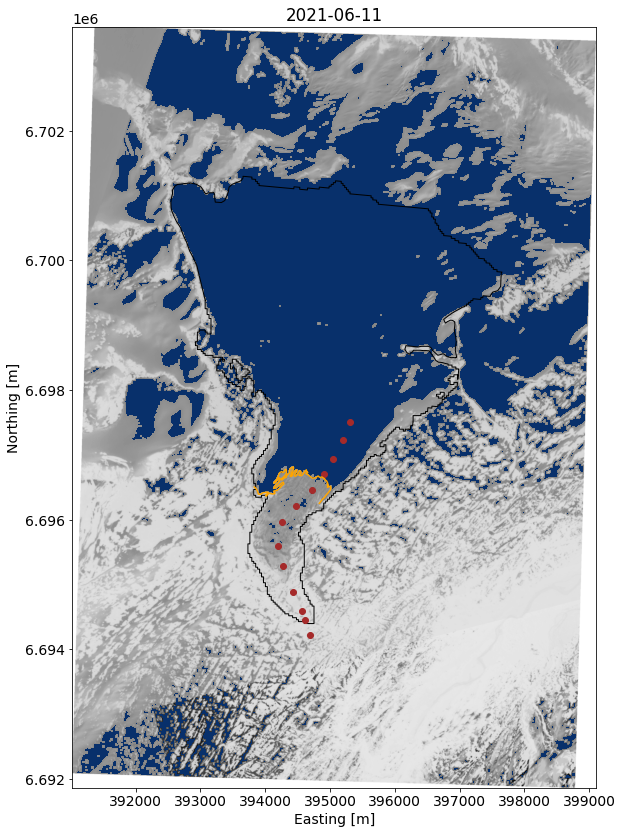

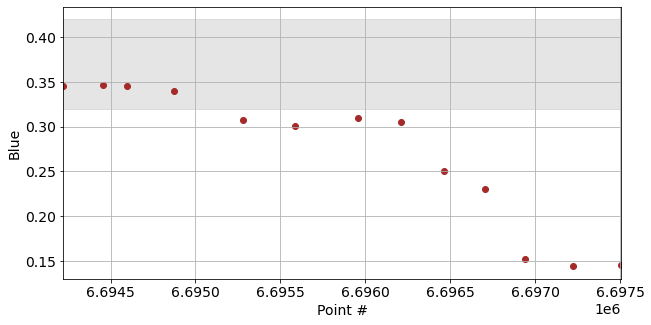

In [57]:
# plot 
fig1, ax1 = plt.subplots(1,1,figsize=(14,14))
plt.rcParams.update({'font.size': 14})
# MNDSI, snow, snowline, and transect locations
show(blue, transform=im.transform, cmap='Greys', ax=ax1)
show(snow, transform=im.transform, cmap='Blues', clim=(0,1), ax=ax1)
AOI.plot(ax=ax1, facecolor='none', edgecolor='black')
sl.plot(ax=ax1, linestyle='-', color='orange')
ax1.scatter(ts_x, ts_y, color='brown')
ax1.set_title('2021-06-11')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
# MNDSI values along transect
fig2, ax2 = plt.subplots(1,1, figsize=(10,5))
plt.rcParams.update({'font.size': 14})
ax2.set_xlim(np.min(ts_y), np.max(ts_y))
rect=matplotlib.patches.Rectangle((ax2.get_xlim()[0],thresh_min),ax2.get_xlim()[1]-ax2.get_xlim()[0],thresh_max-thresh_min, 
                        fill=True, color="grey", alpha=0.2, label='threshold')
plt.gca().add_patch(rect)
ax2.scatter(ts_y, np.flip(ts_blue), color='brown', label='MNDSI')
ax2.set_xlabel('Point #')
ax2.set_ylabel('Blue')
ax2.grid()
plt.show()

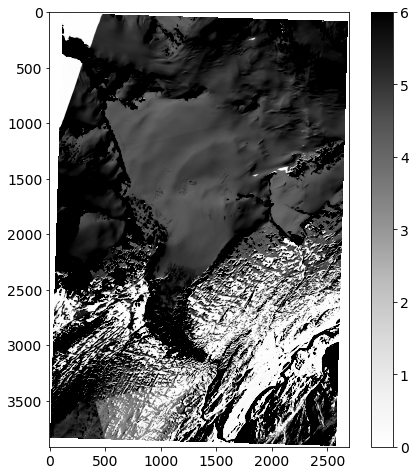

In [32]:
fig = plt.figure(figsize=(8,8))
plt.imshow(mndsi, cmap='Greys', clim=(0,6))
plt.colorbar()
plt.show()